# Project: Wrangling and Analyze Data

In [528]:
# install dependencies
import seaborn as sns
import pandas as pd
import numpy as np
import datetime
import requests
import tweepy 
import re

## Data Gathering
In the cell below, gather **all** three pieces of data for this project and load them in the notebook. **Note:** the methods required to gather each data are different.
1. Directly download the WeRateDogs Twitter archive data (twitter_archive_enhanced.csv)

In [529]:
archive  = pd.read_csv('twitter-archive-enhanced.csv')

2. Use the Requests library to download the tweet image prediction (image_predictions.tsv)

In [530]:
# function to write file from URL
gather = lambda url, file: open(file, 'wb').write(requests.get(url).content)

url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
fileName = 'image_predictions.tsv'

gather(url, fileName)

images = pd.read_csv(fileName, sep='\t')

3. Use the Tweepy library to query additional data via the Twitter API (tweet_json.txt)

In [531]:
url = 'https://video.udacity-data.com/topher/2018/November/5be5fb7d_tweet-json/tweet-json.txt'
fileName = 'tweet_json.txt'

gather(url, fileName)

tweets = pd.read_json(fileName, lines=True)
pd.options.display.max_columns = None

## Assessing Data
In this section, detect and document at least **eight (8) quality issues and two (2) tidiness issue**. You must use **both** visual assessment
programmatic assessement to assess the data.

**Note:** pay attention to the following key points when you access the data.

* You only want original ratings (no retweets) that have images. Though there are 5000+ tweets in the dataset, not all are dog ratings and some are retweets.
* Assessing and cleaning the entire dataset completely would require a lot of time, and is not necessary to practice and demonstrate your skills in data wrangling. Therefore, the requirements of this project are only to assess and clean at least 8 quality issues and at least 2 tidiness issues in this dataset.
* The fact that the rating numerators are greater than the denominators does not need to be cleaned. This [unique rating system](http://knowyourmeme.com/memes/theyre-good-dogs-brent) is a big part of the popularity of WeRateDogs.
* You do not need to gather the tweets beyond August 1st, 2017. You can, but note that you won't be able to gather the image predictions for these tweets since you don't have access to the algorithm used.



### Quality issues

1. _Archive table:_ missing **in_reply_to_status_id, in_reply_to_user_id, retweeted_status_user_id, retweeted_status_timestamp, expanded_urls** values and **source** field not necessary

2. _Archive table:_ missrepresentation of missing data in **name, doggo, floofer, pupper, puppo** values - Missing data in theses columns is of type, 'None'(str) instead of np.nan(float)

3. _Archive table:_ **timestamp** should be a datetime value

4. _Archive table:_ some values in **name** have hidden dog names in the **text** field - for example, the value 'a' of index, 56, should actually be 'Wiley'

5. _Archive table:_ some tweets are not dog ratings and are not retweets

6. _Archive table:_ tweets beyond August 1st, 2017 are not needed.

7. _Archive table:_ get only original tweets

8. _Archive table:_ **rating_denominator** should have max of 10

9. _Tweets table:_ missing **extended_entities, in_reply_to_status_id, in_reply_to_status_id_str, in_reply_to_user_id, in_reply_to_user_id_str, in_reply_to_screen_name, user, geo, coordinates, place, contributors, possibly_sensitive, possibly_sensitive_appealable, retweeted_status, quoted_status_id, quoted_status_id_str, quoted_status** values

### Tidiness issues
1. _Tweets table:_ **display_text_range** range should be a single value 

2. _Archive table:_ dog stage represented as 4 columns should be booleans 

## Cleaning Data
In this section, clean **all** of the issues you documented while assessing. 

**Note:** Make a copy of the original data before cleaning. Cleaning includes merging individual pieces of data according to the rules of [tidy data](https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html). The result should be a high-quality and tidy master pandas DataFrame (or DataFrames, if appropriate).

**values in retweet-id are retweets**
<br>
**Rating denominators are not all 10**

In [532]:
# Make copies of original pieces of data
tweetsCopy = tweets.copy()
imagesCopy = images.copy()
archiveCopy = archive.copy()

### Issue 1: 
_Archive table:_ missing **in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp, expanded_urls** values

#### Define:
The data to replace these missing values is not available and also, some of the columns are not so important. so the decision is to drop these columns.

#### Code

In [533]:
columns = ['in_reply_to_status_id', 'in_reply_to_user_id', 'source',
'retweeted_status_user_id', 'retweeted_status_timestamp', 'expanded_urls']
archiveCopy.drop(columns=columns, axis=1, inplace=True)

#### Test

In [534]:
print('These is the number of columns before cleaning:', len(archive.columns))
print('These is the number of columns after cleaning:', len(archiveCopy.columns))

These is the number of columns before cleaning: 17
These is the number of columns after cleaning: 11


### Issue 2:
_Archive table:_ missrepresentation of missing data in **name, doggo, floofer, pupper, puppo** values - Missing data in theses columns is of type, 'None'(str) instead of np.nan(float)

#### Define:
'None' values in **name, doggo, floofer, pupper, puppo** columns should be converted to np.nan
#### Code

In [535]:
archiveCopy[archiveCopy.loc[:] == 'None'] = np.nan;

#### Test

In [536]:
archiveCopy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   tweet_id             2356 non-null   int64  
 1   timestamp            2356 non-null   object 
 2   text                 2356 non-null   object 
 3   retweeted_status_id  181 non-null    float64
 4   rating_numerator     2356 non-null   int64  
 5   rating_denominator   2356 non-null   int64  
 6   name                 1611 non-null   object 
 7   doggo                97 non-null     object 
 8   floofer              10 non-null     object 
 9   pupper               257 non-null    object 
 10  puppo                30 non-null     object 
dtypes: float64(1), int64(3), object(7)
memory usage: 202.6+ KB


### Issue 3:
_Archive table:_ **timestamp** should be a datetime value

#### Define:
use the `pd.to_datetime()` to change the **timestamp** column from object to datetime
#### Code

In [537]:
archiveCopy.timestamp = pd.to_datetime(archiveCopy.timestamp, utc=False, infer_datetime_format=True)

#### Test

In [538]:
print('This is the type of column before cleaning:', type(archive.timestamp[0]))
print('This is the type of column after cleaning:', type(archiveCopy.timestamp[0]))

This is the type of column before cleaning: <class 'str'>
This is the type of column after cleaning: <class 'pandas._libs.tslibs.timestamps.Timestamp'>


### Issue 4:
_Archive table:_ some values in **name** have hidden dog names in the **text** field - for example, the value 'a' of index, 56, should actually be 'Wiley'

#### Define:

1. Find all values in names that are not dog names
2. for such values, check if a name exists in the **text** field
2. if names exists, input name in the **name** field, else input a NaN value

#### Code

In [539]:
# find values in name fieldd that are not names of dogs
values = set()
for name in archiveCopy.name:
    values.add(name)

# copy the non name values into a list. ecluding NaN values, and values that do not have a name in the text field
values = ['a', 'actually', 'all', 'an', 'by', 'getting', 'his', 'incredibly', 'infuriating', 'just', 'life', 'light', 
'mad', 'my', 'not','officially', 'old', 'one', 'quite', 'space', 'such', 'the', 'this', 'unacceptable', 'very'] 
# a(named/name is), an(named), his(That is), my(name is), one(for) - words in bracket are filters for texts with dog names

# make a function to replace wrong value in name with the right dog name in text
def change(value, sift, expression):
    tempDF = archiveCopy.text[archiveCopy.name == value]
    index = archiveCopy.text[archiveCopy.name == value].index

    for row in tempDF:
        if sift in row:
            name = re.search(expression,row).group()
            for i in index:
                archiveCopy.name.iloc[i] = archiveCopy.name.iloc[i].replace(value, name);

# function call on entries with  hidden dog names
value = 'a'
sift = 'named'
expression = '(?<=named )(\w+)'
change(value, sift, expression)

value = 'a'
sift = 'name is'
expression = '(?<=name is )(\w+)'
change(value, sift, expression)

value = 'an'
sift = 'named'
expression = '(?<=named )(\w+)'
change(value, sift, expression)

value = 'his'
sift = 'That is'
expression = '(?<=That is )(\w+)'
change(value, sift, expression)

value = 'my'
sift = 'name is'
expression = '(?<=name is )(\w+)'
change(value, sift, expression)

value = 'one'
sift = 'for'
expression = '(?<=for )(\w+)'
change(value, sift, expression)

for item in values:
    archiveCopy[archiveCopy.loc[:] == item] = np.nan

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


#### Test

In [540]:
print('This is the cell of index 56 before cleaning:', archive.name.iloc[56])
print('This is the cell of index 56 after cleaning:', archiveCopy.name.iloc[56], '\n') #or quinzo in 992
archiveCopy.info()

This is the cell of index 56 before cleaning: a
This is the cell of index 56 after cleaning: Wylie 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   tweet_id             2356 non-null   int64         
 1   timestamp            2356 non-null   datetime64[ns]
 2   text                 2356 non-null   object        
 3   retweeted_status_id  181 non-null    float64       
 4   rating_numerator     2356 non-null   int64         
 5   rating_denominator   2356 non-null   int64         
 6   name                 1570 non-null   object        
 7   doggo                97 non-null     object        
 8   floofer              10 non-null     object        
 9   pupper               257 non-null    object        
 10  puppo                30 non-null     object        
dtypes: datetime64[ns](1), float64(1), int64(3), ob

### Issue 5:
_Archive table:_ some tweets are not dog ratings and are not retweets

#### Define:
filter the image predictions for only true values and perform an outer join with the twitter archive to get only dog ratings
#### Code

In [541]:
# filter for only imges that have p1_dog True because, p1_dog has the highest cofidence
imagesCopy = imagesCopy[imagesCopy.p1_dog == True].reset_index(drop=True)

# drop unecessary columns from imagesCopy
columns = ['jpg_url', 'img_num', 'p1_dog', 'p1_conf', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog']
imagesCopy.drop(columns=columns, axis=1, inplace=True)

# Join tables and rename the p1 column
archiveCopy = archiveCopy.merge(imagesCopy, on='tweet_id', how='inner') #, lsuffix='left', rsuffix='right')
archiveCopy.rename(columns={'p1':'dog_breed'}, inplace=True)

#### Test

In [542]:
archiveCopy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1532 entries, 0 to 1531
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   tweet_id             1532 non-null   int64         
 1   timestamp            1532 non-null   datetime64[ns]
 2   text                 1532 non-null   object        
 3   retweeted_status_id  55 non-null     float64       
 4   rating_numerator     1532 non-null   int64         
 5   rating_denominator   1532 non-null   int64         
 6   name                 1131 non-null   object        
 7   doggo                63 non-null     object        
 8   floofer              8 non-null      object        
 9   pupper               158 non-null    object        
 10  puppo                20 non-null     object        
 11  dog_breed            1532 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(3), object(7)
memory usage: 155.6+ KB


### Issue 6:
_Archive table:_ tweets beyond August 1st, 2017 are not needed.

#### Define:
filter for tweets before August 1st, 2017
#### Code

In [543]:
archiveCopy = archiveCopy[archiveCopy.timestamp < pd.Timestamp(2017,8,2).floor('D')]

#### Test

In [544]:
archiveCopy.timestamp.max()

Timestamp('2017-08-01 00:17:27')

### Issue 7:
_Archive table:_ get only original tweets

#### Define:
filter the **retweeted_status_id** for NaN values
#### Code

In [545]:
# First RTs - filter the tweets for cases where retweeted_status_id == np.nan
archiveCopy = archiveCopy[archiveCopy.retweeted_status_id.isin([np.nan])].reset_index(drop=True)

# delete the retweeted_status_id' column
archiveCopy.drop('retweeted_status_id', axis=1, inplace=True)

# Remove QTs next
columns = ['created_at','id_str', 'full_text', 'truncated', 'entities', 'extended_entities', 'source', 'in_reply_to_status_id', 'in_reply_to_status_id_str', 
'in_reply_to_user_id', 'in_reply_to_user_id_str','in_reply_to_screen_name', 'user', 'geo', 'coordinates', 'place', 'contributors','is_quote_status', 
'favorited', 'retweeted','possibly_sensitive_appealable', 'lang', 'retweeted_status', 'quoted_status_id_str', 'quoted_status', 'display_text_range', 'retweet_count', 'favorite_count', 'possibly_sensitive']

tweetsCopy1 = tweetsCopy.drop(columns=columns, axis=1)
tweetsCopy1.rename(columns={'id':'tweet_id'}, inplace=True)
tweetsCopy1 = tweetsCopy1[tweetsCopy1.quoted_status_id.isin([np.nan])].reset_index(drop=True)
archiveCopy = archiveCopy.merge(tweetsCopy1, on='tweet_id', how='inner')

archiveCopy.drop('quoted_status_id', axis=1, inplace=True)

#### Test

In [546]:
archiveCopy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1477 entries, 0 to 1476
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   tweet_id            1477 non-null   int64         
 1   timestamp           1477 non-null   datetime64[ns]
 2   text                1477 non-null   object        
 3   rating_numerator    1477 non-null   int64         
 4   rating_denominator  1477 non-null   int64         
 5   name                1093 non-null   object        
 6   doggo               58 non-null     object        
 7   floofer             8 non-null      object        
 8   pupper              152 non-null    object        
 9   puppo               20 non-null     object        
 10  dog_breed           1477 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(7)
memory usage: 138.5+ KB


### Issue 8:
_Archive table:_ **rating_denominator** should have max of 10
#### Define:
convert all values in rating_denominator to 10
#### Code

In [547]:
integers = [0, 16, 120, 170, 15, 50, 80, 2, 7, 11, 20, 40, 70, 90, 110, 130, 150]
archiveCopy[archiveCopy.rating_denominator.isin(integers)] = 10

#### Test

In [548]:
integers = len(archive.rating_denominator.value_counts().index)
print('This is the number of values before cleaning:', integers)

integers = len(archiveCopy.rating_denominator.value_counts().index)
print('This is the number of values after cleaning:', integers)

This is the number of values before cleaning: 18
This is the number of values after cleaning: 1


In [549]:
archiveCopy

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,dog_breed
0,892177421306343426,2017-08-01 00:17:27,This is Tilly. She's just checking pup on you....,13,10,Tilly,NaN,NaN,NaN,NaN,Chihuahua
1,891815181378084864,2017-07-31 00:18:03,This is Archie. He is a rare Norwegian Pouncin...,12,10,Archie,NaN,NaN,NaN,NaN,Chihuahua
2,891327558926688256,2017-07-29 16:00:24,This is Franklin. He would like you to stop ca...,12,10,Franklin,NaN,NaN,NaN,NaN,basset
3,891087950875897856,2017-07-29 00:08:17,Here we have a majestic great white breaching ...,13,10,NaN,NaN,NaN,NaN,NaN,Chesapeake_Bay_retriever
4,890971913173991426,2017-07-28 16:27:12,Meet Jax. He enjoys ice cream so much he gets ...,13,10,Jax,NaN,NaN,NaN,NaN,Appenzeller
...,...,...,...,...,...,...,...,...,...,...,...
1472,666049248165822465,2015-11-16 00:24:50,Here we have a 1949 1st generation vulpix. Enj...,5,10,NaN,NaN,NaN,NaN,NaN,miniature_pinscher
1473,666044226329800704,2015-11-16 00:04:52,This is a purebred Piers Morgan. Loves to Netf...,6,10,Wylie,NaN,NaN,NaN,NaN,Rhodesian_ridgeback
1474,666033412701032449,2015-11-15 23:21:54,Here is a very happy pup. Big fan of well-main...,9,10,Wylie,NaN,NaN,NaN,NaN,German_shepherd
1475,666029285002620928,2015-11-15 23:05:30,This is a western brown Mitsubishi terrier. Up...,7,10,Wylie,NaN,NaN,NaN,NaN,redbone


### Issue 9:
_Tweets table:_ missing **extended_entities, in_reply_to_status_id, in_reply_to_status_id_str, in_reply_to_user_id, in_reply_to_user_id_str, in_reply_to_screen_name, user, geo, coordinates, place, contributors, possibly_sensitive, possibly_sensitive_appealable, retweeted_status, quoted_status_id, quoted_status_id_str, quoted_status** values
#### Define:
#### Code

In [550]:
columns = ['created_at','id_str', 'full_text', 'truncated', 'entities', 'extended_entities', 'source', 'in_reply_to_status_id', 'in_reply_to_status_id_str', 
'in_reply_to_user_id', 'in_reply_to_user_id_str','in_reply_to_screen_name', 'user', 'geo', 'coordinates', 'place', 'contributors','is_quote_status', 
'favorited', 'retweeted','possibly_sensitive_appealable', 'lang', 'retweeted_status', 'possibly_sensitive','quoted_status_id', 'quoted_status_id_str', 'quoted_status']

tweetsCopy.drop(columns=columns, axis=1, inplace=True)

#### Test

In [551]:
print('These is the number of columns before cleaning:', len(tweets.columns))
print('These is the number of columns after cleaning:', len(tweetsCopy.columns))

These is the number of columns before cleaning: 31
These is the number of columns after cleaning: 4


### Issue 10:
_Tweets table:_ **display_text_range** range should be a single value 

#### Define:
input only the last element of each list in the display_text_range column
#### Code

In [552]:
list = []
for row in tweetsCopy.display_text_range:
    list.append(row[-1])
len(list)

tweetsCopy.display_text_range = pd.Series(list)

# rename id column so as to join with archive
tweetsCopy.rename(columns={'id':'tweet_id'}, inplace=True)
archiveCopy = archiveCopy.merge(tweetsCopy, on='tweet_id', how='inner')

#### Test

In [553]:
print('Type of display_text_range before cleaning:', type(tweets.display_text_range[0]))
print('Type of display_text_range after cleaning:', type(tweetsCopy.display_text_range[0]))

Type of display_text_range before cleaning: <class 'list'>
Type of display_text_range after cleaning: <class 'numpy.int64'>


### Issue 11:
_Archive table:_ dog stage represented as 4 columns should be categorical

#### Define:
fill hidden dog stages and then represent columns as booleans
#### Code

In [554]:
# input values where stages are hidden
def fill(stage):
    for text in archiveCopy.text[archiveCopy[stage] != stage]:
        if stage in text:
            index = archiveCopy[archiveCopy.text == text].index
            archiveCopy[stage].iloc[index] = stage;

stages = ['doggo', 'floofer','pupper', 'puppo']
for stage in stages:
    fill(stage)

# archiveCopy = archiveCopy[(archiveCopy.doggo == 'doggo') | (archiveCopy.puppo == 'puppo') | (archiveCopy.floofer == 'floofer') | (archiveCopy.pupper == 'pupper')]

# Create boolean values
archiveCopy['doggo'] = archiveCopy['doggo'] == 'doggo'
archiveCopy['puppo'] = archiveCopy['puppo'] == 'puppo'
archiveCopy['floofer'] = archiveCopy['floofer'] == 'floofer'
archiveCopy['pupper'] = archiveCopy['pupper'] == 'pupper'

# select ratings that are one of ['doggo', 'floofer','pupper', 'puppo']
archiveCopy = archiveCopy[(archiveCopy.doggo == True) | (archiveCopy.puppo == True) | (archiveCopy.floofer == True) | (archiveCopy.pupper == True)]
archiveCopy.dropna(axis=1, inplace=True)
archiveCopy.reset_index(drop=True)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,tweet_id,timestamp,text,rating_numerator,rating_denominator,doggo,floofer,pupper,puppo,dog_breed,display_text_range,retweet_count,favorite_count
0,890240255349198849,2017-07-26 15:59:51,This is Cassie. She is a college pup. Studying...,14,10,True,False,False,False,Pembroke,133,7711,32467
1,889665388333682689,2017-07-25 01:55:32,Here's a puppo that seems to be on the fence a...,13,10,False,False,False,True,Pembroke,106,8538,38818
2,889531135344209921,2017-07-24 17:02:04,This is Stuart. He's sporting his favorite fan...,13,10,False,False,False,True,golden_retriever,118,2321,15359
3,886366144734445568,2017-07-15 23:25:31,This is Roscoe. Another pupper fallen victim t...,12,10,False,False,True,False,French_bulldog,131,3316,21524
4,884162670584377345,2017-07-09 21:29:42,Meet Yogi. He doesn't have any important dog m...,12,10,True,False,False,False,German_shepherd,140,3128,20771
...,...,...,...,...,...,...,...,...,...,...,...,...,...
238,672622327801233409,2015-12-04 03:43:54,This lil pupper is sad because we haven't foun...,12,10,False,False,True,False,golden_retriever,128,542,1377
239,672594978741354496,2015-12-04 01:55:13,Meet Scott. Just trying to catch his train to ...,9,10,False,False,True,False,Great_Pyrenees,137,661,1411
240,672481316919734272,2015-12-03 18:23:34,Say hello to Jazz. She should be on the cover ...,12,10,False,False,True,False,Border_collie,101,137,757
241,672254177670729728,2015-12-03 03:21:00,This is Rolf. He's having the time of his life...,11,10,False,False,True,False,pug,89,800,1515


#### Test

In [555]:
archiveCopy.head()

,tweet_id,timestamp,text,rating_numerator,rating_denominator,doggo,floofer,pupper,puppo,dog_breed,display_text_range,retweet_count,favorite_count
7,890240255349198849,2017-07-26 15:59:51,This is Cassie. She is a college pup. Studying...,14,10,True,False,False,False,Pembroke,133,7711,32467
10,889665388333682689,2017-07-25 01:55:32,Here's a puppo that seems to be on the fence a...,13,10,False,False,False,True,Pembroke,106,8538,38818
12,889531135344209921,2017-07-24 17:02:04,This is Stuart. He's sporting his favorite fan...,13,10,False,False,False,True,golden_retriever,118,2321,15359
24,886366144734445568,2017-07-15 23:25:31,This is Roscoe. Another pupper fallen victim t...,12,10,False,False,True,False,French_bulldog,131,3316,21524
33,884162670584377345,2017-07-09 21:29:42,Meet Yogi. He doesn't have any important dog m...,12,10,True,False,False,False,German_shepherd,140,3128,20771


In [561]:
archiveCopy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243 entries, 7 to 1251
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_id            243 non-null    int64 
 1   timestamp           243 non-null    object
 2   text                243 non-null    object
 3   rating_numerator    243 non-null    int64 
 4   rating_denominator  243 non-null    int64 
 5   doggo               243 non-null    bool  
 6   floofer             243 non-null    bool  
 7   pupper              243 non-null    bool  
 8   puppo               243 non-null    bool  
 9   dog_breed           243 non-null    object
 10  display_text_range  243 non-null    int64 
 11  retweet_count       243 non-null    int64 
 12  favorite_count      243 non-null    int64 
dtypes: bool(4), int64(6), object(3)
memory usage: 19.9+ KB


## Storing Data
Save gathered, assessed, and cleaned master dataset to a CSV file named "twitter_archive_master.csv".

In [562]:
archiveCopy.to_csv('twitter_archive_master.csv')

## Analyzing and Visualizing Data
In this section, analyze and visualize your wrangled data. You must produce at least **three (3) insights and one (1) visualization.**

In [563]:
print('Breed count:','\n', archiveCopy.dog_breed.value_counts(), '\n')
print('Highset retweets:', archiveCopy.retweet_count.max())
print('Highest likes:', archiveCopy.favorite_count.max())

Breed count: 
 golden_retriever      33
Labrador_retriever    17
Pembroke              13
Pomeranian             9
Chihuahua              8
                      ..
basset                 1
Brabancon_griffon      1
Brittany_spaniel       1
Leonberg               1
clumber                1
Name: dog_breed, Length: 79, dtype: int64 

Highset retweets: 79515
Highest likes: 132810


### Insights:
1. golden_retriever is the most common dog breed

2. The most liked tweet has 132,810 likes

3. The most retweeted tweet has 132810 retweets

### Visualization

<AxesSubplot:xlabel='variable', ylabel='count'>

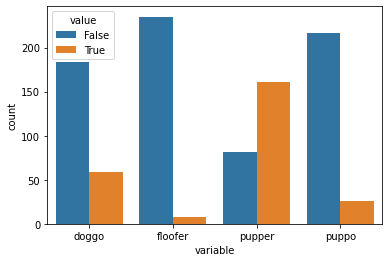

In [559]:
# subset columns
values = archiveCopy[['doggo', 'floofer', 'pupper', 'puppo']]
values = values.reset_index(drop=True)

# plot
sns.countplot(x='variable', hue='value', data=pd.melt(values))